# Model Predictive Control

In [1]:
import os
import time
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
import matplotlib.pyplot as plt
from casadi import (
    MX, DM, Function, Opti, integrator,
    vec, vcat, vertcat, horzcat, 
    sum1, sum2, sumsqr, sin, cos,
    gradient, jacobian, hessian
)

import casadi
casadi.__version__

'3.6.4'

In [2]:
import matplotlib
matplotlib.__version__

'3.8.0'

In [3]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

## Cart-pole System

Inverted pendulum on a horizontally-constrained cart:

<img src='images/cart_pend_diagram.png' width=300>

The system is controlled by a force acting in the x-direction on the cart. The system is described by a four-dimensional state-space:

$$ x = \left[\begin{matrix} p \\ \theta \\ \dot{p} \\ \dot{\theta} \end{matrix}\right]$$

In [4]:
# Physical constants
g = 9.81     # gravitation [m/s^2]
L = 0.2      # pendulum length [m]
m = 1        # pendulum mass [kg]
mcart = 0.5  # cart mass [kg]

T = 2.0  # control horizon [s]
N = 160  # Number of control intervals
dt = T/N  # length of 1 control interval [s]

# System is composed of 4 states
nx = 4

In [5]:
speedup = 4  # 0..4

In [6]:
# CasADi function for the ODE right-hand side
xk = MX.sym('x',nx) # states: pos [m], theta [rad], dpos [m/s], dtheta [rad/s]
uk = MX.sym('u') # control force [N]
ddpos = (
    (uk + m * L * xk[3] * xk[3] * sin(xk[1]) - m * g * sin(xk[1]) * cos(xk[1]))
    / (mcart + m - m * cos(xk[1]) * cos(xk[1]))
)
rhs = vertcat(xk[2], xk[3], ddpos, g/L * sin(xk[1]) - cos(xk[1]) * ddpos)

# Continuous-time system dynamics
f = Function('f', [xk, uk], [rhs], ['xk', 'uk'], ['dxdt'])
f

Function(f:(xk[4],uk)->(dxdt[4]) MXFunction)

In [7]:
# Discrete-time system dynamics
intg_options = {'number_of_finite_elements': 1}
if speedup >= 3:
    intg_options['simplify'] = 1

# Reference Runge-Kutta implementation
solver = 'rk'
dae = {'x': xk, 'p': uk, 'ode': f(xk, uk)}
t0 = 0
tf = dt / intg_options['number_of_finite_elements']
intg = integrator('intg', solver, dae, t0, tf, intg_options)
print(intg)
res = intg(x0=xk, p=uk)
xf = res['xf']

# Discretized system dynamics
F = Function('F', [xk, uk], [xf], ['xk', 'uk'], ['xkp1'])
F

intg:(x0[4],z0[0],p,u[0],adj_xf[],adj_zf[],adj_qf[])->(xf[4],zf[],qf[0],adj_x0[],adj_z0[],adj_p[],adj_u[]) MXFunction


Function(F:(xk[4],uk)->(xkp1[4]) MXFunction)

## Reference optimal control using multiple shooting

Optimal control problem using multiple shooting

$$
\DeclareMathOperator * {\minimize}{minimize}
\begin{aligned}
\minimize_{x_1,x_2,...,x_{N+1},u_1,u_2,...,u_N} \quad & \sum_{k=1}^{N}{u_k^2} \\
\text{subject to} \quad & F(x_k,u_k) = x_{k+1}, \quad k=1, ..., N \\
                  & -3 \le x_k \le 3, \quad k=1, ..., N+1 \\
                  & -1.2 \le u_k \le 1.2, \quad k=1, ..., N \\
                  & x_1 = \left[\begin{matrix}1 & 0 & 0 & 0\end{matrix}\right]^T \\
                  & x_{N+1} = \left[\begin{matrix}0 & 0 & 0 & 0\end{matrix}\right]^T \\
\end{aligned}
$$

In [8]:
opti = casadi.Opti()

# Decision variables for states
X = opti.variable(nx, N+1)

# Aliases for states
pos    = X[0, :]
theta  = X[1, :]
dpos   = X[2, :]
dtheta = X[3, :]

# Decision variables for control vector
U = opti.variable(N, 1)  # force [N]

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:,k],U[k]))

# Path constraints
opti.subject_to(opti.bounded(-3,  pos, 3)) # Syntax -3 <= pos <= 3 not supported in Python
opti.subject_to(opti.bounded(-1.2, U, 1.2))

# Initial and terminal constraints
opti.subject_to(X[:, 0] == vertcat(1, 0, 0, 0))
opti.subject_to(X[:, -1] == vertcat(0, 0, 0, 0))

# Objective: regularization of controls
opti.minimize(sumsqr(U))

# solve optimization problem
opti.solver('ipopt')

sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3048
Number of nonzeros in inequality constraint Jacobian.:      321
Number of nonzeros in Lagrangian Hessian.............:      960

Total number of variables............................:      804
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      648
Total number of inequality c

## Plot functions

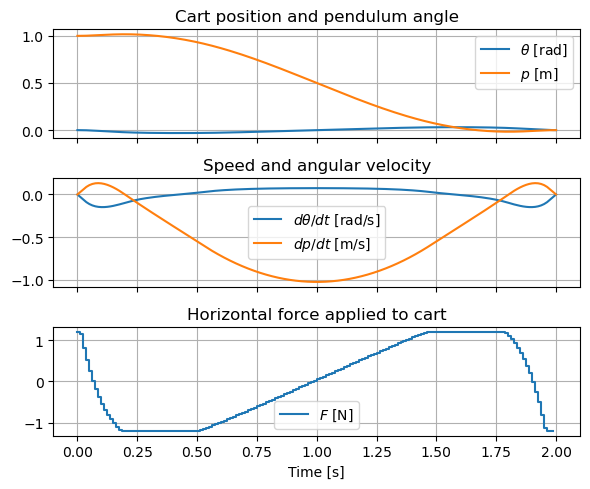

In [9]:
def make_ioplots(t, pos, theta, dpos, dtheta, u, 
                 figsize=(6, 5)):

    fig, axes = plt.subplots(3, 1, sharex=True, 
                             figsize=figsize)
    
    ax = axes[0]
    ax.plot(t, theta, label=r'$\theta$ [rad]')
    ax.plot(t, pos, label=r'$p$ [m]')
    ax.legend()
    ax.grid()
    ax.set_title('Cart position and pendulum angle')
    
    ax = axes[1]
    ax.plot(t, dtheta, label=r'$d\theta/dt$ [rad/s]')
    ax.plot(t, dpos, label=r'$dp/dt$ [m/s]')
    ax.legend()
    ax.grid()
    ax.set_title('Speed and angular velocity')
    
    ax = axes[2]
    ax.step(t[:-1], u, label=r'$F$ [N]')
    ax.set_xlabel('Time [s]')
    ax.legend()
    ax.grid()
    ax.set_title('Horizontal force applied to cart')

    plt.tight_layout()

pos_opt = sol.value(pos)
theta_opt = sol.value(theta)
dpos_opt = sol.value(dpos)
dtheta_opt = sol.value(dtheta)
u_opt = sol.value(U)
tgrid = np.linspace(0, T, N+1)

make_ioplots(tgrid, pos_opt, theta_opt, dpos_opt, dtheta_opt, u_opt)
filename = 'mpc_solution_1_ioplot.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

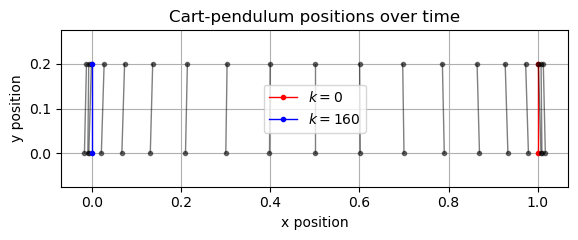

In [10]:
def pend_sequence_plot(pos, theta, k_step=8, L=L, figsize=(6, 2.5)):

    cart_pos = np.stack([pos, np.zeros_like(pos)])
    end_pos = np.stack([pos + L * np.sin(theta), L * np.cos(theta)])
    N = end_pos.shape[1]

    fig, ax = plt.subplots(figsize=figsize)

    k_values = list(range(0, N, k_step))
    labels = []
    for k in k_values:
        if k == 0:
            style, alpha, label = ('r.-', 1, f'$k = {k}$')
        elif k == k_values[-1]:
            style, alpha, label = ('b.-', 1, f'$k = {k}$')
        else:
            style, alpha, label = ('k.-', 0.5, None)
        ax.plot([cart_pos[0, k], end_pos[0, k]], 
                [cart_pos[1, k], end_pos[1, k]], 
                style, linewidth=1, alpha=alpha, label=label)

    ax.axis('equal')
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.grid()
    ax.legend()
    ax.set_title('Cart-pendulum positions over time')

    return ax

ax = pend_sequence_plot(pos_opt, theta_opt)
plt.tight_layout()
filename = 'mpc_solution_1_seq.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

## 1. Basic implementation of MPC

### 1.1 Add a strong regularization term on the cart position

$$
\DeclareMathOperator * {\minimize}{minimize}
\begin{aligned}
\minimize_{x_1,x_2,...,x_{N+1},u_1,u_2,...,u_N} \quad & \sum_{k=1}^{N}{u_k^2} + \color{red}{1000 \sum_{k=1}^{N+1}{p_k^2}} \\
\text{subject to} \quad & F(x_k,u_k) = x_{k+1}, \quad k=1, ..., N \\
                  & -3 \le x_k \le 3, \quad k=1, ..., N+1 \\
                  & -1.2 \le u_k \le 1.2, \quad k=1, ..., N \\
                  & x_1 = \left[\begin{matrix}1 & 0 & 0 & 0\end{matrix}\right]^T \\
                  & x_{N+1} = \left[\begin{matrix}0 & 0 & 0 & 0\end{matrix}\right]^T \\
\end{aligned}
$$


In [11]:
opti = casadi.Opti()

# Decision variables for states
X = opti.variable(nx, N + 1)

# Aliases for states
pos    = X[0, :]
theta  = X[1, :]
dpos   = X[2, :]
dtheta = X[3, :]

# Decision variables for control vector
U = opti.variable(N, 1)  # force [N]

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:, k], U[k]))

# Path constraints
opti.subject_to(opti.bounded(-3, pos, 3))  # Syntax -3 <= pos <= 3 not supported in Python
opti.subject_to(opti.bounded(-1.2, U, 1.2))

# Initial and terminal constraints
opti.subject_to(X[:, 0] == vertcat(1, 0, 0, 0))
opti.subject_to(X[:, -1] == vertcat(0, 0, 0, 0))

# Objective: regularization of controls + cart position
opti.minimize(sumsqr(U) + 1000 * sumsqr(pos))

opti.solver('ipopt')

# solve optimization problem
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3048
Number of nonzeros in inequality constraint Jacobian.:      321
Number of nonzeros in Lagrangian Hessian.............:     1121

Total number of variables............................:      804
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      648
Total number of inequality constraints...............:      321
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      321
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

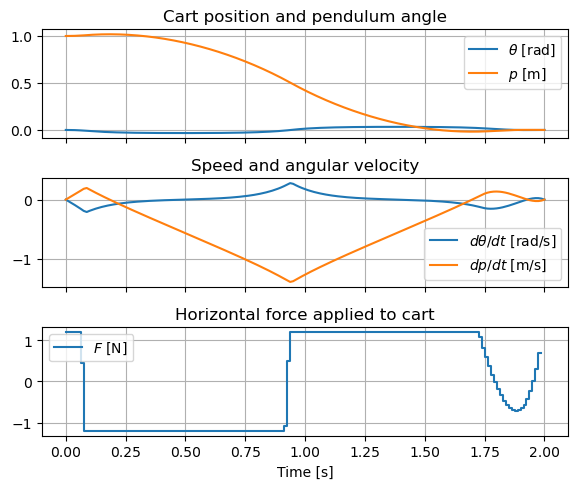

In [12]:
pos_opt = sol.value(pos)
theta_opt = sol.value(theta)
dpos_opt = sol.value(dpos)
dtheta_opt = sol.value(dtheta)
u_opt = sol.value(U)
tgrid = np.linspace(0, T, N+1)

make_ioplots(tgrid, pos_opt, theta_opt, dpos_opt, dtheta_opt, u_opt)
filename = 'mpc_solution_1_1_ioplot.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

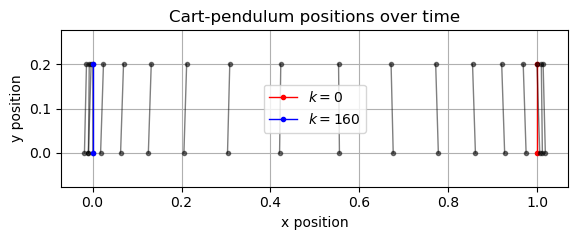

In [13]:
ax = pend_sequence_plot(pos_opt, theta_opt)
plt.tight_layout()
filename = 'mpc_solution_1_1_seq.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

### 1.2 Introduce a parameter for the initial state of the OCP

In [14]:
opti = casadi.Opti()

# Decision variables for states
X = opti.variable(nx, N + 1)

# Aliases for states
pos    = X[0, :]
theta  = X[1, :]
dpos   = X[2, :]
dtheta = X[3, :]

# Decision variables for control vector
U = opti.variable(N, 1)  # force [N]

# Parameter for initial state
x0 = opti.parameter(nx)

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:, k], U[k]))

# Path constraints
opti.subject_to(opti.bounded(-3, pos, 3))  # Syntax -3 <= pos <= 3 not supported in Python
opti.subject_to(opti.bounded(-1.2, U, 1.2))

# Initial and terminal constraints
opti.subject_to(X[:, 0] == x0)
opti.subject_to(X[:, -1] == vertcat(0, 0, 0, 0))

# Objective: regularization of controls + cart position
opti.minimize(sumsqr(U) + 1000 * sumsqr(pos))

opti.solver('ipopt')

# solve optimization problem
opti.set_value(x0, vertcat(0.5, 0, 0, 0))
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3048
Number of nonzeros in inequality constraint Jacobian.:      321
Number of nonzeros in Lagrangian Hessian.............:     1121

Total number of variables............................:      804
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      648
Total number of inequality constraints...............:      321
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      321
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.00e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

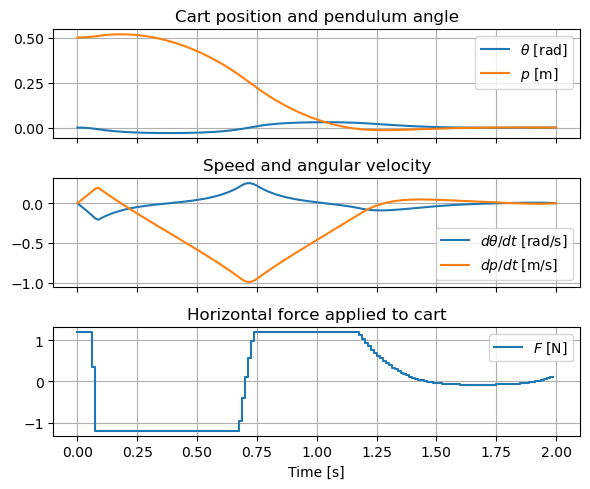

In [15]:
pos_opt = sol.value(pos)
theta_opt = sol.value(theta)
dpos_opt = sol.value(dpos)
dtheta_opt = sol.value(dtheta)
u_opt = sol.value(U)
tgrid = np.linspace(0, T, N+1)

make_ioplots(tgrid, pos_opt, theta_opt, dpos_opt, dtheta_opt, u_opt)
filename = 'mpc_solution_1_2_ioplot.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

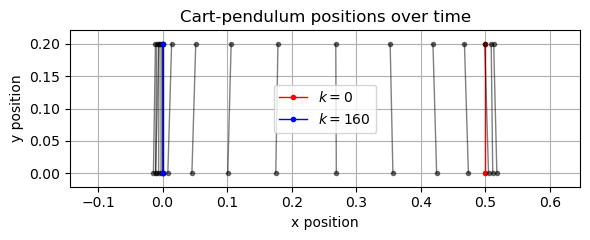

In [16]:
ax = pend_sequence_plot(pos_opt, theta_opt)
plt.tight_layout()
filename = 'mpc_solution_1_2_seq.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

### 1.3. & 1.4 Implement MPC loop for 5 sample periods and silence NLP solver output

In [17]:
Nsim = 5
xk = vertcat(0.5, 0, 0, 0)

options = dict()
options["ipopt"] = {"print_level": 0}
opti.solver('ipopt', options)

x_history = DM.zeros(nx, N)
u_history = DM.zeros(1, N)

for i in range(Nsim):

    t0 = time.time()

    # Get first control action from solver solution
    uk = sol.value(U[0])
    u_history[:, i] = uk

    # Simulate the system over dt
    current_x = F(xk, uk)
    x_history[:, i] = xk

    # Set the value of parameter x0 to the current x
    opti.set_value(x0, xk)

    # Solve the NLP
    sol = opti.solve()

    print(f"{i:03d}: {time.time() - t0:.5f}")

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 111.00us (  3.96us)  99.92us (  3.57us)        28
       nlp_g  |  19.11ms (682.57us)  18.99ms (678.27us)        28
  nlp_grad_f  | 154.00us (  5.31us) 142.13us (  4.90us)        29
  nlp_hess_l  | 307.78ms ( 11.40ms) 307.22ms ( 11.38ms)        27
   nlp_jac_g  | 170.24ms (  5.87ms) 169.99ms (  5.86ms)        29
       total  | 594.39ms (594.39ms) 592.98ms (592.98ms)         1
000: 0.63843
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 210.00us (  3.75us) 189.88us (  3.39us)        56
       nlp_g  |  38.65ms (690.16us)  38.53ms (688.02us)        56
    nlp_grad  |   2.42ms (  2.42ms)   2.41ms (  2.41ms)         1
  nlp_grad_f  | 301.00us (  5.19us) 279.28us (  4.82us)        58
  nlp_hess_l  | 606.28ms ( 11.23ms) 606.25ms ( 11.23ms)        54
   nlp_jac_g  | 331.89ms (  5.72ms) 331.75ms (  5.72ms)        58
       total  | 582.96ms (582.96ms) 584.13ms (584.13ms)        

Each MPC iteration takes about 0.6 to 0.9 seconds

## 2. Speeding up the implementation

In [18]:
opti = Opti()

# Decision variables for states
X = opti.variable(nx, N + 1)

# Aliases for states
pos    = X[0, :]
theta  = X[1, :]
dpos   = X[2, :]
dtheta = X[3, :]

# Decision variables for control vector
U =  opti.variable(N, 1)  # force [N]

# Parameter for initial state
x0 = opti.parameter(nx)

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:, k], U[k]))

# Path constraints
opti.subject_to(opti.bounded(-3, pos, 3))
opti.subject_to(opti.bounded(-1.2, U, 1.2))

# Initial and terminal constraints
opti.subject_to(X[:, 0] == x0)
opti.subject_to(X[:, -1] == vertcat(0, 0, 0, 0))

# Objective: regularization of controls + additional
# regularization of cart position
opti.minimize(sumsqr(U) + 1000 * sumsqr(pos))

## Solve optimization problem

In [19]:
options = {'print_time': False}

if speedup >= 3:
    options['expand'] = True  # expand makes function evaluations faster but requires more memory

if speedup >= 2:
    options['qpsol'] = 'qrqp';
    options['qpsol_options'] = {'print_iter': False, 'print_header': False}
    options['print_iteration'] = False
    options['print_header'] = False
    options['print_status'] = False
    opti.solver('sqpmethod', options)
else:
    options['ipopt'] = {'print_level': 0}
    opti.solver('ipopt', options)

opti.set_value(x0, vertcat(0.5, 0, 0, 0))

sol = opti.solve()
sol

OptiSol(Opti {
  instance #3
  #variables: 2 (nx = 804)
  #parameters: 1 (np = 4)
  #constraints: 164 (ng = 969)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

## MPC loop

In [20]:
current_x = vertcat(0.5, 0, 0, 0)

N = 400
x_history = DM.zeros(nx, N)
u_history = DM.zeros(1, N)

np.random.seed(0)

print('MPC running')

if speedup < 4:

    for i in range(N):
        t0 = time.time()
        # What control signal should I apply?
        u_sol = sol.value(U[0])

        u_history[:, i] = u_sol

        # Simulate the system over dt
        current_x = F(current_x, u_sol)
        if i > 200:
          current_x = current_x + vertcat([0, 0, 0, 0.01 * np.random.rand()])

        if speedup >= 1:
            # Set the initial values to the previous results
            opti.set_initial(opti.x, sol.value(opti.x)) # decision variables
            opti.set_initial(opti.lam_g, sol.value(opti.lam_g)) # multipliers

        # Set the value of parameter x0 to the current x
        opti.set_value(x0, current_x)

        # Solve the NLP
        sol = opti.solve()

        x_history[:,i] = current_x
        print(f"{i:03d}: {time.time() - t0:.5f}")

if speedup >= 4:
    inputs = [x0, opti.x, opti.lam_g]
    outputs = [U[0], opti.x, opti.lam_g]
    mpc_step = opti.to_function('mpc_step', inputs, outputs)
    print(mpc_step)
    
    u = sol.value(U[0])
    x = sol.value(opti.x)
    lam = sol.value(opti.lam_g)
    
    for i in range(N):
        t0 = time.time()
        u_history[:, i] = u
        
        # Simulate the system over dt
        current_x = F(current_x, u)
        if i > 200:
          current_x = current_x + vertcat([0, 0, 0, 0.01 * np.random.rand()])
        
        u, x, lam = mpc_step(current_x, x, lam)

        x_history[:, i] = current_x
        print(f"{i:03d}: {time.time() - t0:.5f}")


MPC running
mpc_step:(i0[4],i1[804],i2[969])->(o0,o1[804],o2[969]) MXFunction
000: 0.01137
001: 0.02132
002: 0.01566
003: 0.01118
004: 0.02108
005: 0.01562
006: 0.01374
007: 0.02028
008: 0.01558
009: 0.01791
010: 0.01136
011: 0.01172
012: 0.01645
013: 0.01246
014: 0.01478
015: 0.01075
016: 0.01553
017: 0.01385
018: 0.01567
019: 0.01452
020: 0.01402
021: 0.01290
022: 0.01885
023: 0.01174
024: 0.00975
025: 0.01661
026: 0.01459
027: 0.01614
028: 0.01066
029: 0.01833
030: 0.01920
031: 0.01770
032: 0.01687
033: 0.01282
034: 0.01309
035: 0.01325
036: 0.01096
037: 0.00914
038: 0.01706
039: 0.01405
040: 0.01550
041: 0.01796
042: 0.01230
043: 0.01195
044: 0.01429
045: 0.01553
046: 0.01112
047: 0.01072
048: 0.02019
049: 0.01236
050: 0.00788
051: 0.01435
052: 0.01428
053: 0.01213
054: 0.01045
055: 0.01664
056: 0.01454
057: 0.01147
058: 0.01304
059: 0.01165
060: 0.00853
061: 0.00987
062: 0.00781
063: 0.01697
064: 0.00743
065: 0.00886
066: 0.01307
067: 0.02089
068: 0.01292
069: 0.01625
070: 0.01741

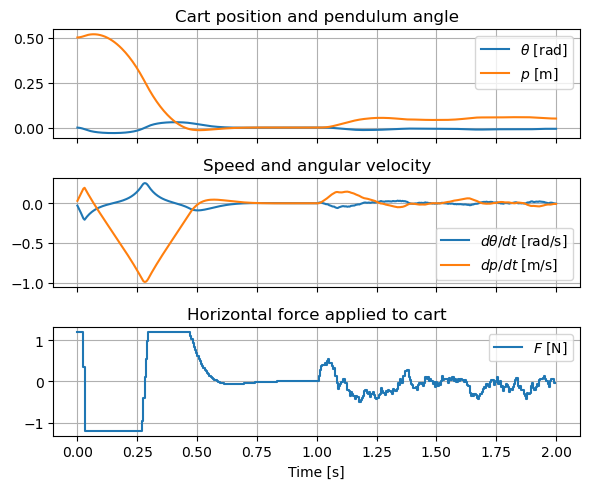

In [21]:
pos_opt = sol.value(x_history[0, :])
theta_opt = sol.value(x_history[1, :])
dpos_opt = sol.value(x_history[2, :])
dtheta_opt = sol.value(x_history[3, :])
u_opt = sol.value(u_history)
tgrid = np.linspace(0, T, N)

make_ioplots(tgrid, pos_opt, theta_opt, dpos_opt, dtheta_opt, u_opt[:-1])
filename = 'mpc_solution_2_ioplot.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

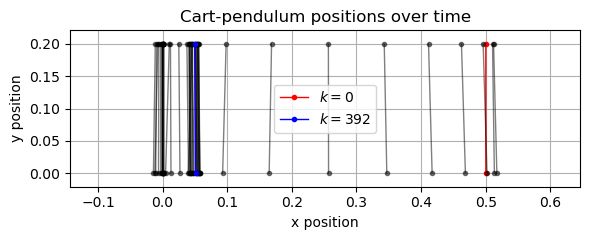

In [22]:
ax = pend_sequence_plot(pos_opt, theta_opt)
plt.tight_layout()
filename = 'mpc_solution_2_seq.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()